# Convolutional Neural Networks

In this step, we will train the mnist data with Convolutional Neural Networks, a.k.a CNNs.

Convolutional Neural Network is a very popular deep learning method especially in the fields of computer vision.

Contrast to DBN which tries to resolve the overfitting issue with initialization, CNN tries to address this problem with reduced model complexity.

The convolution layer and pooling layer drastically reduces the model complexity compared to other deep learning methods, and consequently prevents overfitting in an extremely efficient way.

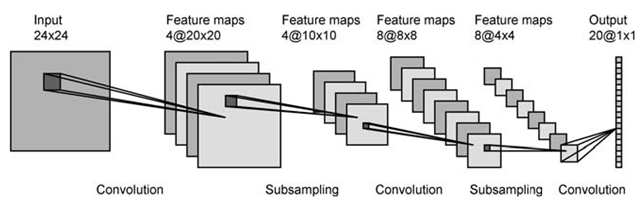

In [1]:
itorch.image('./ConvolutionalNeuralNetwork/CNN.png')

# Convolution

As you can see above, CNN mainly features what we call 'filters' and convolves it around the entire image.

By every step of convolution, a particular feature is calculated, and this will eventually form a spacial map, which we call 'feature maps'.

The convolution steps are as below

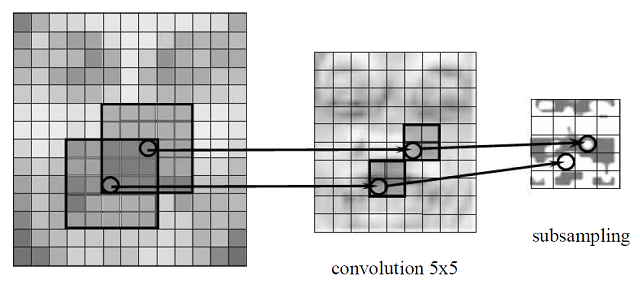

In [2]:
itorch.image('./ConvolutionalNeuralNetwork/convolution.png')

# CIFAR-10 dataset

We will first train the mnist dataset. It will contain 60000 training dataset and 10000 test dataset.

First, prepare the dataset by importing the essential libraries.